In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils, callbacks
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from tensorflow.keras.utils import custom_object_scope
from matplotlib.colors import ListedColormap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import zipfile
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback

import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
! mkdir Music_Symbols
%cd Music_Symbols

!cp /content/drive/MyDrive/MESTRADO_UFU/bioinspirada/trabalho_automato_2/Music_Symbols.zip .

!unzip Music_Symbols.zip
!rm Music_Symbols.zip

## Data

In [ ]:
def load_and_preprocess_clef(zip_file_path):
    """
    Load and preprocess images from clef folders inside the given zip file.

    :param zip_file_path: Path to the zip file containing the Music_Symbols dataset.
    :return: Binarized clef images and their one-hot encoded labels.
    """
    return _load_and_preprocess_from_zip(zip_file_path, prefix="CLEF")


def load_and_preprocess_accidental(zip_file_path):
    """
    Load and preprocess images from accidental folders inside the given zip file.

    :param zip_file_path: Path to the zip file containing the Music_Symbols dataset.
    :return: Binarized accidental images and their one-hot encoded labels.
    """
    return _load_and_preprocess_from_zip(zip_file_path, prefix="ACCIDENTAL")


def _load_and_preprocess_from_zip(zip_file_path, prefix, target_size=(32, 32)):
    """
    Generic function to load and preprocess images from specified folders in the zip file.

    :param zip_file_path: Path to the zip file containing the dataset.
    :param prefix: Prefix of folders to process (e.g., "CLEF" or "ACCIDENTAL").
    :param target_size: Tuple indicating the target size to resize images (default is 32x32).
    :return: Binarized images and their one-hot encoded labels.
    """

    temp_dir = "temp_extracted"
    os.makedirs(temp_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    images = []
    labels = []

    folder_names = [f for f in os.listdir(temp_dir) if f.startswith(prefix)]
    for folder_name in folder_names:
        label = folder_name.split("_")[-1]
        folder_path = os.path.join(temp_dir, folder_name)

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path).convert("L")
            image = image.resize(target_size)
            image = np.array(image)
            image = (image >= 128).astype(np.float32)
            images.append(image)
            labels.append(label)


    for root, dirs, files in os.walk(temp_dir, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    os.rmdir(temp_dir)


    unique_labels = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_to_index[label] for label in labels]


    images = np.array(images)
    labels = np.array(labels)


    images = np.expand_dims(images, axis=-1)


    labels = tf.keras.utils.to_categorical(labels, len(unique_labels))

    return images, labels

def load_and_preprocess_mnist():
    """
    Load and preprocess the MNIST dataset with binarization.

    :return: Binarized MNIST images and their one-hot encoded labels.
    """

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


    x_data = np.concatenate([x_train, x_test], axis=0)
    y_data = np.concatenate([y_train, y_test], axis=0)

    x_data = (x_data >= 128).astype(np.float32)

    x_data = np.expand_dims(x_data, axis=-1)

    y_data = tf.keras.utils.to_categorical(y_data, 10)

    return x_data, y_data

zip_file_path = "/content/drive/MyDrive/MESTRADO_UFU/bioinspirada/trabalho_automato_2/Music_Symbols.zip"


clef_images, clef_labels = load_and_preprocess_clef(zip_file_path)
print(f"Clef images shape: {clef_images.shape}")
print(f"Clef labels shape: {clef_labels.shape}")

accidental_images, accidental_labels = load_and_preprocess_accidental(zip_file_path)
print(f"Accidental images shape: {accidental_images.shape}")
print(f"Accidental labels shape: {accidental_labels.shape}")


Clef images shape: (2128, 32, 32, 1)
Clef labels shape: (2128, 3)
Accidental images shape: (1966, 32, 32, 1)
Accidental labels shape: (1966, 4)


In [ ]:
from sklearn.model_selection import train_test_split, KFold
# Define the LeNet-5 architecture
def create_lenet5(input_shape, n_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(6, kernel_size=(5, 5), activation="tanh", input_shape=input_shape, padding="same"))
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.Conv2D(16, kernel_size=(5, 5), activation="tanh"))


    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=2))
    model.add(layers.Conv2D(120, kernel_size=(3, 3), activation="tanh"))

    model.add(layers.Flatten())
    model.add(layers.Dense(84, activation="tanh"))
    model.add(layers.Dense(n_classes, activation="softmax"))

    return model


In [ ]:
model = create_lenet5((32,32,1), 10)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 16, 16, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 6, 6, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 120)           │          17,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 84)                  │         161,364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,186 (711.66 KB)

 Trainable params: 182,186 (711.66 KB)

 Non-trainable params: 0 (0.00 B)

## LeNet-5 Convolutional Layers

In [ ]:


def cross_validate_lenet5(dados):
    if dados == 'clef':
      x_data, y_data = load_and_preprocess_clef(zip_file_path)
    elif dados == 'accidentals':
      x_data, y_data = load_and_preprocess_accidental(zip_file_path)
    elif dados == 'mnist':
      x_data, y_data = load_and_preprocess_mnist()

    n_classes = y_data.shape[1]
    input_shape = x_data.shape[1:]

    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Epochs to evaluate
    save_epochs = [5, 15, 25, 50, 100]
    #save_epochs = [5]
    metrics = {epoch: [] for epoch in save_epochs}
    evaluation_times = {epoch: [] for epoch in save_epochs}
    training_times = {epoch: [] for epoch in save_epochs}

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
        print(f"Starting fold {fold + 1}")

        x_train_full, x_val = x_data[train_idx], x_data[val_idx]
        y_train_full, y_val = y_data[train_idx], y_data[val_idx]

        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=0.2, random_state=42
        )

        model = create_lenet5(input_shape, n_classes)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        # Save model weights at specific epochs
        checkpoint_path = f"lenet5_fold{fold + 1}_epoch_{{epoch:02d}}.h5"

        epoch_start_time = None
        current_epoch = 0
        training_times_accumulator = 0

        def save_on_epoch(epoch, logs):
            nonlocal epoch_start_time, training_times_accumulator, current_epoch

            if epoch_start_time is not None:
                training_times_accumulator += time.time() - epoch_start_time

            epoch_start_time = time.time()
            current_epoch = epoch + 1

            if current_epoch in save_epochs:
                training_times[current_epoch].append(training_times_accumulator)
                model.save(checkpoint_path.format(epoch=current_epoch))

        checkpoint_callback = callbacks.LambdaCallback(on_epoch_end=save_on_epoch)

        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=max(save_epochs),
            batch_size=32,
            callbacks=[checkpoint_callback],
            verbose=1
        )


        for epoch in save_epochs:
            model_path = f"lenet5_fold{fold + 1}_epoch_{epoch:02d}.h5"
            saved_model = models.load_model(model_path)

            start_time = time.time()
            val_loss, val_accuracy = saved_model.evaluate(x_val, y_val, verbose=0)
            end_time = time.time()

            elapsed_time = end_time - start_time
            evaluation_times[epoch].append(elapsed_time)

            metrics[epoch].append(val_accuracy)
            print(f"Fold {fold + 1}, Epoch {epoch}: Val Accuracy: {val_accuracy:.4f}, Evaluation Time: {elapsed_time:.2f} seconds")

    for epoch in save_epochs:
        print('BASE: ', dados)
        mean_acc = np.mean(metrics[epoch])
        std_acc = np.std(metrics[epoch])
        mean_eval_time = np.mean(evaluation_times[epoch])
        mean_train_time = np.mean(training_times[epoch]) if training_times[epoch] else 0.0
        print(f"Epoch {epoch}: Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}, Mean Eval Time: {mean_eval_time:.2f} seconds, Mean Train Time: {mean_train_time:.2f} seconds")

dados = ['accidentals', 'clef', 'mnist']
#dados = ['accidentals']

for x in dados:
  cross_validate_lenet5(x)


Starting fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.6827 - loss: 0.8144 - val_accuracy: 0.8881 - val_loss: 0.3475
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9053 - loss: 0.2702 - val_accuracy: 0.9220 - val_loss: 0.2418
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9299 - loss: 0.2085 - val_accuracy: 0.9424 - val_loss: 0.2192
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9607 - loss: 0.1084 - val_accuracy: 0.9390 - val_loss: 0.2217
Epoch 5/100
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9639 - loss: 0.0936 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9661 - loss: 0.0940 - val_accuracy: 0.9322 - val_loss: 0.2382
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.0703 - val_accuracy: 0.9559 - val_loss: 0.1877
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0517 - val_accuracy: 0.9627 - val_loss: 0.1533
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9928 - loss: 0.0283 - val_accuracy: 0.9593 - val_loss: 0.1539
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0240 - val_accuracy: 0.9661 - val_loss: 0.1406
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0125 - val_accuracy: 0.9593 - val_loss: 0.1370
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0078 - val_accuracy: 0.9661 - val_loss: 0.1290
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9695 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9661 - val_loss: 0.1362
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9695 - val_loss: 0.1370
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9661 - val_loss: 0.1392
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9661 - val_loss: 0.1379
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9661 - val_loss: 0.1396
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9729 - val_loss: 0.1396
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9661 - val_loss: 0.1406
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9729 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9695 - val_loss: 0.1414
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9695 - val_loss: 0.1428
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9695 - val_loss: 0.1426
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5823e-04 - val_accuracy: 0.9729 - val_loss: 0.1421
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9695 - val_loss: 0.1446
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7894e-04 - val_accuracy: 0.9695 - val_loss: 0.1442
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.0915e-04 - val_accuracy: 0.9695 - val_loss: 0.1444
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2503e-04 - val_accuracy:

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0615e-04 - val_accuracy: 0.9729 - val_loss: 0.1523
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5865e-04 - val_accuracy: 0.9729 - val_loss: 0.1501
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4443e-04 - val_accuracy: 0.9729 - val_loss: 0.1507
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3599e-04 - val_accuracy: 0.9729 - val_loss: 0.1525
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3015e-04 - val_accuracy: 0.9729 - val_loss: 0.1501
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2104e-04 - val_accuracy: 0.9729 - val_loss: 0.1506
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4551e-04 - val_accuracy: 0.9729 - val_loss: 0.1523
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9022e-04

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0553e-05 - val_accuracy: 0.9729 - val_loss: 0.1614


Fold 1, Epoch 5: Val Accuracy: 0.9322, Evaluation Time: 1.06 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9661, Evaluation Time: 1.65 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9695, Evaluation Time: 1.69 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9729, Evaluation Time: 1.09 seconds
Fold 1, Epoch 100: Val Accuracy: 0.9729, Evaluation Time: 1.04 seconds
Starting fold 2
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6405 - loss: 0.8551 - val_accuracy: 0.9322 - val_loss: 0.2355
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.2867 - val_accuracy: 0.9559 - val_loss: 0.1660
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.1730 - val_accuracy: 0.9356 - val_loss: 0.1899
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9365 - loss: 0.2048 - val_accuracy: 0.9593 - val_loss: 0.1437
Epoch 5/100
23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9588 - loss: 0.1349  

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.1321 - val_accuracy: 0.9525 - val_loss: 0.1187
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9658 - loss: 0.1143 - val_accuracy: 0.9492 - val_loss: 0.1304
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9755 - loss: 0.0882 - val_accuracy: 0.9729 - val_loss: 0.0907
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9885 - loss: 0.0574 - val_accuracy: 0.9661 - val_loss: 0.0795
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9877 - loss: 0.0449 - val_accuracy: 0.9695 - val_loss: 0.0845
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0354 - val_accuracy: 0.9661 - val_loss: 0.0785
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0250 - val_accuracy: 0.9627 - val_loss: 0.0711
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9962 - loss: 0.0155 - val_accuracy: 0.9763 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9763 - val_loss: 0.0635
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9729 - val_loss: 0.0633
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9763 - val_loss: 0.0622
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9797 - val_loss: 0.0600
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9763 - val_loss: 0.0591
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9763 - val_loss: 0.0585
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9763 - val_loss: 0.0591
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9763 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9797 - val_loss: 0.0570
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9797 - val_loss: 0.0567
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9763 - val_loss: 0.0565
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9797 - val_loss: 0.0556
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9797 - val_loss: 0.0560
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9797 - val_loss: 0.0555
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9763 - val_loss: 0.0548
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9797 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4040e-04 - val_accuracy: 0.9797 - val_loss: 0.0524
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1389e-04 - val_accuracy: 0.9797 - val_loss: 0.0524
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6786e-04 - val_accuracy: 0.9797 - val_loss: 0.0527
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4691e-04 - val_accuracy: 0.9831 - val_loss: 0.0527
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9047e-04 - val_accuracy: 0.9797 - val_loss: 0.0529
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7965e-04 - val_accuracy: 0.9797 - val_loss: 0.0530
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4423e-04 - val_accuracy: 0.9797 - val_loss: 0.0521
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6107e-04

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.5265e-05 - val_accuracy: 0.9763 - val_loss: 0.0499


Fold 2, Epoch 5: Val Accuracy: 0.9525, Evaluation Time: 1.03 seconds


Fold 2, Epoch 15: Val Accuracy: 0.9763, Evaluation Time: 1.06 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9797, Evaluation Time: 1.06 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9797, Evaluation Time: 1.56 seconds
Fold 2, Epoch 100: Val Accuracy: 0.9763, Evaluation Time: 1.58 seconds
Starting fold 3
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6409 - loss: 0.8826 - val_accuracy: 0.8915 - val_loss: 0.2827
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8974 - loss: 0.2962 - val_accuracy: 0.9186 - val_loss: 0.2063
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9299 - loss: 0.2185 - val_accuracy: 0.9356 - val_loss: 0.1881
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9641 - loss: 0.1268 - val_accuracy: 0.9390 - val_loss: 0.1855
Epoch 5/100
23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9692 - loss: 0.1052 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.1113 - val_accuracy: 0.9525 - val_loss: 0.1621
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.0928 - val_accuracy: 0.9492 - val_loss: 0.1517
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9801 - loss: 0.0729 - val_accuracy: 0.9525 - val_loss: 0.1542
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9852 - loss: 0.0508 - val_accuracy: 0.9559 - val_loss: 0.1376
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9878 - loss: 0.0443 - val_accuracy: 0.9729 - val_loss: 0.0907
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0238 - val_accuracy: 0.9695 - val_loss: 0.0939
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0167 - val_accuracy: 0.9593 - val_loss: 0.1037
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0101 - val_accuracy: 0.9695 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9695 - val_loss: 0.0892
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9695 - val_loss: 0.0918
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9729 - val_loss: 0.0905
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9661 - val_loss: 0.0910
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9695 - val_loss: 0.0900
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9695 - val_loss: 0.0929
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9695 - val_loss: 0.0908
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9695 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9695 - val_loss: 0.0919
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9695 - val_loss: 0.0915
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9695 - val_loss: 0.0947
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9695 - val_loss: 0.0948
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9695 - val_loss: 0.0929
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9695 - val_loss: 0.0954
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6194e-04 - val_accuracy: 0.9695 - val_loss: 0.0962
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9695 - va

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9156e-04 - val_accuracy: 0.9695 - val_loss: 0.1002
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1889e-04 - val_accuracy: 0.9729 - val_loss: 0.0996
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6854e-04 - val_accuracy: 0.9695 - val_loss: 0.1008
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0615e-04 - val_accuracy: 0.9729 - val_loss: 0.1011
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9799e-04 - val_accuracy: 0.9729 - val_loss: 0.1006
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9680e-04 - val_accuracy: 0.9729 - val_loss: 0.1002
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3347e-04 - val_accuracy: 0.9729 - val_loss: 0.1012
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6380e-04

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.7837e-05 - val_accuracy: 0.9729 - val_loss: 0.1102


Fold 3, Epoch 5: Val Accuracy: 0.9525, Evaluation Time: 1.93 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9695, Evaluation Time: 1.07 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9695, Evaluation Time: 1.06 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9695, Evaluation Time: 1.05 seconds
Fold 3, Epoch 100: Val Accuracy: 0.9729, Evaluation Time: 1.39 seconds
Starting fold 4
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.6469 - loss: 0.8512 - val_accuracy: 0.8814 - val_loss: 0.3233
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8984 - loss: 0.2670 - val_accuracy: 0.9390 - val_loss: 0.1757
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9648 - loss: 0.1346 - val_accuracy: 0.9458 - val_loss: 0.1329
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9738 - loss: 0.0952 - val_accuracy: 0.9458 - val_loss: 0.1587
Epoch 5/100
22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1155 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9620 - loss: 0.1048 - val_accuracy: 0.9559 - val_loss: 0.1017
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9797 - loss: 0.0682 - val_accuracy: 0.9627 - val_loss: 0.0895
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0354 - val_accuracy: 0.9627 - val_loss: 0.0825
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9935 - loss: 0.0230 - val_accuracy: 0.9661 - val_loss: 0.1092
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9943 - loss: 0.0211 - val_accuracy: 0.9763 - val_loss: 0.0746
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0176 - val_accuracy: 0.9729 - val_loss: 0.0957
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0153 - val_accuracy: 0.9763 - val_loss: 0.0736
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9797 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9831 - val_loss: 0.0562
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9797 - val_loss: 0.0553
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9797 - val_loss: 0.0563
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9831 - val_loss: 0.0544
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9797 - val_loss: 0.0546
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9831 - val_loss: 0.0544
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9797 - val_loss: 0.0547
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9797 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2913e-04 - val_accuracy: 0.9831 - val_loss: 0.0531
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6959e-04 - val_accuracy: 0.9831 - val_loss: 0.0523
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6509e-04 - val_accuracy: 0.9864 - val_loss: 0.0536
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6188e-04 - val_accuracy: 0.9831 - val_loss: 0.0538
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2599e-04 - val_accuracy: 0.9864 - val_loss: 0.0525
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6724e-04 - val_accuracy: 0.9864 - val_loss: 0.0533
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8761e-04 - val_accuracy: 0.9864 - val_loss: 0.0507
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9119e-04

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1775e-04 - val_accuracy: 0.9864 - val_loss: 0.0505
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0442e-04 - val_accuracy: 0.9898 - val_loss: 0.0499
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1383e-04 - val_accuracy: 0.9864 - val_loss: 0.0508
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1182e-04 - val_accuracy: 0.9864 - val_loss: 0.0504
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9337e-04 - val_accuracy: 0.9864 - val_loss: 0.0504
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7889e-04 - val_accuracy: 0.9898 - val_loss: 0.0496
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7702e-04 - val_accuracy: 0.9864 - val_loss: 0.0505
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5596e-04

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.8517e-05 - val_accuracy: 0.9864 - val_loss: 0.0501


Fold 4, Epoch 5: Val Accuracy: 0.9559, Evaluation Time: 1.55 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9831, Evaluation Time: 1.57 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9831, Evaluation Time: 1.07 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9864, Evaluation Time: 1.04 seconds
Fold 4, Epoch 100: Val Accuracy: 0.9864, Evaluation Time: 1.15 seconds
BASE:  accidentals
Epoch 5: Mean Accuracy: 0.9483, Std Dev: 0.0094, Mean Eval Time: 1.39 seconds, Mean Train Time: 2.97 seconds
BASE:  accidentals
Epoch 15: Mean Accuracy: 0.9737, Std Dev: 0.0065, Mean Eval Time: 1.34 seconds, Mean Train Time: 5.52 seconds
BASE:  accidentals
Epoch 25: Mean Accuracy: 0.9754, Std Dev: 0.0061, Mean Eval Time: 1.22 seconds, Mean Train Time: 7.76 seconds
BASE:  accidentals
Epoch 50: Mean Accuracy: 0.9771, Std Dev: 0.0065, Mean Eval Time: 1.19 seconds, Mean Train Time: 12.79 seconds
BASE:  accidentals
Epoch 100: Mean Accuracy: 0.9771, Std Dev: 0.0056, Mean Eval Time: 1.29 seconds, Mean Train Time: 23.38 seconds
Starting fold 1
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.7391 - loss: 0.5844 - val_accuracy: 0.9375 - val_loss: 0.1575
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.94

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.1021 - val_accuracy: 0.9688 - val_loss: 0.0707
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.0582 - val_accuracy: 0.9688 - val_loss: 0.0620
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.0476 - val_accuracy: 0.9719 - val_loss: 0.0830
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0458 - val_accuracy: 0.9719 - val_loss: 0.0613
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0277 - val_accuracy: 0.9719 - val_loss: 0.0477
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0255 - val_accuracy: 0.9812 - val_loss: 0.0452
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 0.9781 - val_loss: 0.0485
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0114 - val_accuracy: 0.9812 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0056 - val_accuracy: 0.9781 - val_loss: 0.0528
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9781 - val_loss: 0.0445
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9812 - val_loss: 0.0326
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9812 - val_loss: 0.0348
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9812 - val_loss: 0.0379
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9812 - val_loss: 0.0374
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9812 - val_loss: 0.0361
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9812 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3896e-04 - val_accuracy: 0.9812 - val_loss: 0.0397
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.3467e-04 - val_accuracy: 0.9812 - val_loss: 0.0372
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7269e-04 - val_accuracy: 0.9812 - val_loss: 0.0381
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2460e-04 - val_accuracy: 0.9812 - val_loss: 0.0379
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2227e-04 - val_accuracy: 0.9812 - val_loss: 0.0378
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7332e-04 - val_accuracy: 0.9812 - val_loss: 0.0378
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1607e-04 - val_accuracy: 0.9844 - val_loss: 0.0381
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9649e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2434e-04 - val_accuracy: 0.9844 - val_loss: 0.0372
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8566e-04 - val_accuracy: 0.9844 - val_loss: 0.0372
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4248e-04 - val_accuracy: 0.9844 - val_loss: 0.0380
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2855e-04 - val_accuracy: 0.9844 - val_loss: 0.0371
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0375e-04 - val_accuracy: 0.9844 - val_loss: 0.0381
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9242e-04 - val_accuracy: 0.9844 - val_loss: 0.0372
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7571e-04 - val_accuracy: 0.9844 - val_loss: 0.0379
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4305e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.0590e-05 - val_accuracy: 0.9875 - val_loss: 0.0364


Fold 1, Epoch 5: Val Accuracy: 0.9688, Evaluation Time: 0.60 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9781, Evaluation Time: 0.59 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9812, Evaluation Time: 0.97 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9844, Evaluation Time: 0.93 seconds
Fold 1, Epoch 100: Val Accuracy: 0.9875, Evaluation Time: 0.60 seconds
Starting fold 2
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7399 - loss: 0.5882 - val_accuracy: 0.9375 - val_loss: 0.1712
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9378 - loss: 0.1625 - val_accuracy: 0.9531 - val_loss: 0.1209
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9704 - loss: 0.0898 - val_accuracy: 0.9563 - val_loss: 0.1070
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9870 - loss: 0.0487 - val_accuracy: 0.9531 - val_loss: 0.1362
Epoch 5/100
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9758 - loss: 0.0604 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9749 - loss: 0.0639 - val_accuracy: 0.9688 - val_loss: 0.1083
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0390 - val_accuracy: 0.9719 - val_loss: 0.1018
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9847 - loss: 0.0347 - val_accuracy: 0.9719 - val_loss: 0.0901
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0188 - val_accuracy: 0.9719 - val_loss: 0.1172
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9893 - loss: 0.0273 - val_accuracy: 0.9719 - val_loss: 0.1197
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0215 - val_accuracy: 0.9812 - val_loss: 0.0938
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0145 - val_accuracy: 0.9719 - val_loss: 0.1035
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0122 - val_accuracy: 0.9719 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9750 - val_loss: 0.0961
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9781 - val_loss: 0.0964
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9750 - val_loss: 0.0992
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1666e-04 - val_accuracy: 0.9750 - val_loss: 0.0969
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.7094e-04 - val_accuracy: 0.9750 - val_loss: 0.0986
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4180e-04 - val_accuracy: 0.9750 - val_loss: 0.0991
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.4281e-04 - val_accuracy: 0.9781 - val_loss: 0.0996
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2989e-04 - val_accur

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6167e-04 - val_accuracy: 0.9812 - val_loss: 0.0994
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8569e-04 - val_accuracy: 0.9812 - val_loss: 0.1033
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0407e-04 - val_accuracy: 0.9812 - val_loss: 0.1017
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8084e-04 - val_accuracy: 0.9812 - val_loss: 0.1011
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2914e-04 - val_accuracy: 0.9812 - val_loss: 0.1012
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2366e-04 - val_accuracy: 0.9812 - val_loss: 0.1028
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9686e-04 - val_accuracy: 0.9812 - val_loss: 0.1033
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5664e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1881e-04 - val_accuracy: 0.9812 - val_loss: 0.1095
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1907e-04 - val_accuracy: 0.9812 - val_loss: 0.1093
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1097e-04 - val_accuracy: 0.9812 - val_loss: 0.1095
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2218e-05 - val_accuracy: 0.9812 - val_loss: 0.1092
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1360e-04 - val_accuracy: 0.9812 - val_loss: 0.1102
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6844e-05 - val_accuracy: 0.9812 - val_loss: 0.1105
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1107e-05 - val_accuracy: 0.9812 - val_loss: 0.1105
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2024e-05

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3717e-05 - val_accuracy: 0.9812 - val_loss: 0.1201


Fold 2, Epoch 5: Val Accuracy: 0.9688, Evaluation Time: 0.60 seconds


Fold 2, Epoch 15: Val Accuracy: 0.9750, Evaluation Time: 0.62 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9812, Evaluation Time: 0.60 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9812, Evaluation Time: 0.90 seconds
Fold 2, Epoch 100: Val Accuracy: 0.9812, Evaluation Time: 0.59 seconds
Starting fold 3
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6725 - loss: 0.6599 - val_accuracy: 0.9406 - val_loss: 0.1824
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9480 - loss: 0.1458 - val_accuracy: 0.9563 - val_loss: 0.1353
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9571 - loss: 0.1335 - val_accuracy: 0.9563 - val_loss: 0.1338
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9712 - loss: 0.0944 - val_accuracy: 0.9656 - val_loss: 0.1132
Epoch 5/100
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9877 - loss: 0.0427

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9563 - val_loss: 0.1439
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0546 - val_accuracy: 0.9656 - val_loss: 0.0934
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0452 - val_accuracy: 0.9719 - val_loss: 0.0852
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.0289 - val_accuracy: 0.9656 - val_loss: 0.1163
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0408 - val_accuracy: 0.9563 - val_loss: 0.1041
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0307 - val_accuracy: 0.9656 - val_loss: 0.1095
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.9781 - val_loss: 0.0892
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9781 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9750 - val_loss: 0.0850
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9781 - val_loss: 0.0851
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9781 - val_loss: 0.0846
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9781 - val_loss: 0.0857
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5772e-04 - val_accuracy: 0.9750 - val_loss: 0.0829
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9781 - val_loss: 0.0859
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0940e-04 - val_accuracy: 0.9781 - val_loss: 0.0846
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.9848e-04 - val_accuracy: 0.9

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7590e-04 - val_accuracy: 0.9781 - val_loss: 0.0842
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2447e-04 - val_accuracy: 0.9781 - val_loss: 0.0843
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5496e-04 - val_accuracy: 0.9781 - val_loss: 0.0831
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4636e-04 - val_accuracy: 0.9812 - val_loss: 0.0842
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9062e-04 - val_accuracy: 0.9781 - val_loss: 0.0849
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4219e-04 - val_accuracy: 0.9812 - val_loss: 0.0849
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4259e-04 - val_accuracy: 0.9812 - val_loss: 0.0846
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2945e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4542e-04 - val_accuracy: 0.9812 - val_loss: 0.0868
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3443e-04 - val_accuracy: 0.9812 - val_loss: 0.0862
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1053e-04 - val_accuracy: 0.9812 - val_loss: 0.0875
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1315e-04 - val_accuracy: 0.9812 - val_loss: 0.0867
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0834e-04 - val_accuracy: 0.9812 - val_loss: 0.0873
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2224e-04 - val_accuracy: 0.9812 - val_loss: 0.0862
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1590e-04 - val_accuracy: 0.9812 - val_loss: 0.0871
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0206e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5454e-05 - val_accuracy: 0.9812 - val_loss: 0.0898


Fold 3, Epoch 5: Val Accuracy: 0.9563, Evaluation Time: 0.90 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9750, Evaluation Time: 0.83 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9781, Evaluation Time: 1.03 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9812, Evaluation Time: 1.04 seconds
Fold 3, Epoch 100: Val Accuracy: 0.9812, Evaluation Time: 0.63 seconds
Starting fold 4
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6688 - loss: 0.6311 - val_accuracy: 0.9375 - val_loss: 0.1968
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9540 - loss: 0.1513 - val_accuracy: 0.9625 - val_loss: 0.1103
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9709 - loss: 0.1078 - val_accuracy: 0.9625 - val_loss: 0.1051
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.0734 - val_accuracy: 0.9719 - val_loss: 0.1139
Epoch 5/100
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0536 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0577 - val_accuracy: 0.9781 - val_loss: 0.0957
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0399 - val_accuracy: 0.9656 - val_loss: 0.1166
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0504 - val_accuracy: 0.9844 - val_loss: 0.0748
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9890 - loss: 0.0250 - val_accuracy: 0.9812 - val_loss: 0.0830
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0126 - val_accuracy: 0.9719 - val_loss: 0.0974
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9812 - val_loss: 0.0812
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.9781 - val_loss: 0.0982
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0068 - val_accuracy: 0.9812 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9812 - val_loss: 0.0842
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9844 - val_loss: 0.0852
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9812 - val_loss: 0.0864
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9844 - val_loss: 0.0917
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9812 - val_loss: 0.0912
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9812 - val_loss: 0.0914
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.0669e-04 - val_accuracy: 0.9812 - val_loss: 0.0921
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.3832e-04 - val_accuracy: 0.9812 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9295e-04 - val_accuracy: 0.9844 - val_loss: 0.0979
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7126e-04 - val_accuracy: 0.9812 - val_loss: 0.0993
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1766e-04 - val_accuracy: 0.9812 - val_loss: 0.0990
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.6214e-04 - val_accuracy: 0.9812 - val_loss: 0.1000
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6982e-04 - val_accuracy: 0.9812 - val_loss: 0.1000
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7149e-04 - val_accuracy: 0.9812 - val_loss: 0.1011
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0719e-04 - val_accuracy: 0.9812 - val_loss: 0.1029
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0718e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7463e-04 - val_accuracy: 0.9812 - val_loss: 0.1130
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1656e-04 - val_accuracy: 0.9812 - val_loss: 0.1131
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1688e-04 - val_accuracy: 0.9812 - val_loss: 0.1134
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8881e-05 - val_accuracy: 0.9812 - val_loss: 0.1134
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1134e-04 - val_accuracy: 0.9812 - val_loss: 0.1147
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4041e-04 - val_accuracy: 0.9812 - val_loss: 0.1153
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7570e-05 - val_accuracy: 0.9812 - val_loss: 0.1152
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4474e-04

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2438e-05 - val_accuracy: 0.9812 - val_loss: 0.1289


Fold 4, Epoch 5: Val Accuracy: 0.9781, Evaluation Time: 0.60 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9812, Evaluation Time: 0.60 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9844, Evaluation Time: 0.60 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9812, Evaluation Time: 0.59 seconds
Fold 4, Epoch 100: Val Accuracy: 0.9812, Evaluation Time: 0.61 seconds
BASE:  clef
Epoch 5: Mean Accuracy: 0.9680, Std Dev: 0.0078, Mean Eval Time: 0.67 seconds, Mean Train Time: 2.06 seconds
BASE:  clef
Epoch 15: Mean Accuracy: 0.9773, Std Dev: 0.0026, Mean Eval Time: 0.66 seconds, Mean Train Time: 4.56 seconds
BASE:  clef
Epoch 25: Mean Accuracy: 0.9812, Std Dev: 0.0022, Mean Eval Time: 0.80 seconds, Mean Train Time: 6.97 seconds
BASE:  clef
Epoch 50: Mean Accuracy: 0.9820, Std Dev: 0.0014, Mean Eval Time: 0.86 seconds, Mean Train Time: 12.91 seconds
BASE:  clef
Epoch 100: Mean Accuracy: 0.9828, Std Dev: 0.0027, Mean Eval Time: 0.61 seconds, Mean Train Time: 24.60 seconds
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting fold 1
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8580 - loss: 0.4631 - val_accuracy: 0.9516 - val_loss: 0.1660
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3m

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9800 - loss: 0.0614 - val_accuracy: 0.9777 - val_loss: 0.0823
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9827 - loss: 0.0538 - val_accuracy: 0.9780 - val_loss: 0.0723
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9856 - loss: 0.0440 - val_accuracy: 0.9795 - val_loss: 0.0678
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9858 - loss: 0.0436 - val_accuracy: 0.9778 - val_loss: 0.0755
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9861 - loss: 0.0413 - val_accuracy: 0.9820 - val_loss: 0.0669
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9879 - loss: 0.0370 - val_accuracy: 0.9794 - val_loss: 0.0713
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9891 - loss: 0.0337 - val_accuracy: 0.9825 - val_loss: 0.0635
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9889 - loss: 0.0324 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9921 - loss: 0.0235 - val_accuracy: 0.9813 - val_loss: 0.0682
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9909 - loss: 0.0250 - val_accuracy: 0.9844 - val_loss: 0.0582
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9931 - loss: 0.0213 - val_accuracy: 0.9830 - val_loss: 0.0622
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9937 - loss: 0.0186 - val_accuracy: 0.9842 - val_loss: 0.0617
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9924 - loss: 0.0224 - val_accuracy: 0.9834 - val_loss: 0.0609
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accuracy: 0.9846 - val_loss: 0.0634
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9935 - loss: 0.0182 - val_accuracy: 0.9834 - val_loss: 0.0651
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9944 - loss: 0.0180

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9946 - loss: 0.0162 - val_accuracy: 0.9821 - val_loss: 0.0668
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9944 - loss: 0.0170 - val_accuracy: 0.9838 - val_loss: 0.0690
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9953 - loss: 0.0144 - val_accuracy: 0.9831 - val_loss: 0.0658
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9846 - val_loss: 0.0629
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9954 - loss: 0.0138 - val_accuracy: 0.9843 - val_loss: 0.0649
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9850 - val_loss: 0.0617
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9965 - loss: 0.0111 - val_accuracy: 0.9851 - val_loss: 0.0626
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9962 - loss: 0.0109

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9977 - loss: 0.0075 - val_accuracy: 0.9833 - val_loss: 0.0748
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9971 - loss: 0.0077 - val_accuracy: 0.9839 - val_loss: 0.0766
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9854 - val_loss: 0.0757
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9976 - loss: 0.0072 - val_accuracy: 0.9857 - val_loss: 0.0683
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9976 - loss: 0.0067 - val_accuracy: 0.9848 - val_loss: 0.0732
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.9862 - val_loss: 0.0684
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9973 - loss: 0.0082 - val_accuracy: 0.9850 - val_loss: 0.0755
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9986 - loss: 0.0047

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9850 - val_loss: 0.0947


Fold 1, Epoch 5: Val Accuracy: 0.9777, Evaluation Time: 1.45 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9813, Evaluation Time: 1.48 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9821, Evaluation Time: 1.42 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9833, Evaluation Time: 1.42 seconds
Fold 1, Epoch 100: Val Accuracy: 0.9850, Evaluation Time: 1.61 seconds
Starting fold 2
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8554 - loss: 0.4679 - val_accuracy: 0.9544 - val_loss: 0.1549
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9574 - loss: 0.1382 - val_accuracy: 0.9682 - val_loss: 0.1016
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9731 - loss: 0.0871 - val_accuracy: 0.9711 - val_loss: 0.0897
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9773 - loss: 0.0710 - val_accuracy: 0.9749 - val_loss: 0.0807
Epoch 5/100
1292/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0584

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9822 - loss: 0.0585 - val_accuracy: 0.9767 - val_loss: 0.0761
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9838 - loss: 0.0525 - val_accuracy: 0.9750 - val_loss: 0.0815
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9845 - loss: 0.0469 - val_accuracy: 0.9802 - val_loss: 0.0643
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9864 - loss: 0.0401 - val_accuracy: 0.9821 - val_loss: 0.0606
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9895 - loss: 0.0344 - val_accuracy: 0.9805 - val_loss: 0.0669
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9881 - loss: 0.0354 - val_accuracy: 0.9805 - val_loss: 0.0621
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9885 - loss: 0.0342 - val_accuracy: 0.9832 - val_loss: 0.0531
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9912 - loss: 0.0276 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9915 - loss: 0.0266 - val_accuracy: 0.9831 - val_loss: 0.0550
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9937 - loss: 0.0200 - val_accuracy: 0.9803 - val_loss: 0.0672
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9924 - loss: 0.0232 - val_accuracy: 0.9836 - val_loss: 0.0564
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9926 - loss: 0.0217 - val_accuracy: 0.9859 - val_loss: 0.0516
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9941 - loss: 0.0176 - val_accuracy: 0.9834 - val_loss: 0.0577
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9939 - loss: 0.0181 - val_accuracy: 0.9835 - val_loss: 0.0572
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9937 - loss: 0.0189 - val_accuracy: 0.9848 - val_loss: 0.0539
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9942 - loss: 0.0167

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.9843 - val_loss: 0.0547
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9953 - loss: 0.0139 - val_accuracy: 0.9835 - val_loss: 0.0596
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9963 - loss: 0.0117 - val_accuracy: 0.9846 - val_loss: 0.0544
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9947 - loss: 0.0152 - val_accuracy: 0.9847 - val_loss: 0.0593
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 0.9846 - val_loss: 0.0573
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9870 - val_loss: 0.0513
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9956 - loss: 0.0127 - val_accuracy: 0.9860 - val_loss: 0.0515
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9967 - loss: 0.0103

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 0.9868 - val_loss: 0.0575
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 0.9849 - val_loss: 0.0642
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9973 - loss: 0.0073 - val_accuracy: 0.9861 - val_loss: 0.0609
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9870 - val_loss: 0.0627
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9974 - loss: 0.0064 - val_accuracy: 0.9854 - val_loss: 0.0680
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9967 - loss: 0.0092 - val_accuracy: 0.9861 - val_loss: 0.0676
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9979 - loss: 0.0057 - val_accuracy: 0.9864 - val_loss: 0.0603
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9977 - loss: 0.0065

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9869 - val_loss: 0.0663


Fold 2, Epoch 5: Val Accuracy: 0.9767, Evaluation Time: 1.41 seconds
Fold 2, Epoch 15: Val Accuracy: 0.9831, Evaluation Time: 2.90 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9843, Evaluation Time: 1.56 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9868, Evaluation Time: 1.44 seconds
Fold 2, Epoch 100: Val Accuracy: 0.9869, Evaluation Time: 1.40 seconds
Starting fold 3
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8615 - loss: 0.4744 - val_accuracy: 0.9425 - val_loss: 0.1930
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9551 - loss: 0.1525 - val_accuracy: 0.9590 - val_loss: 0.1426
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9688 - loss: 0.1027 - val_accuracy: 0.9686 - val_loss: 0.1035
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9759 - loss: 0.0789 - val_accuracy: 0.9750 - val_loss: 0.0900
Epoch 5/100
1301/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0669

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9797 - loss: 0.0669 - val_accuracy: 0.9787 - val_loss: 0.0732
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9829 - loss: 0.0558 - val_accuracy: 0.9749 - val_loss: 0.0834
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9844 - loss: 0.0486 - val_accuracy: 0.9755 - val_loss: 0.0786
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9873 - loss: 0.0421 - val_accuracy: 0.9766 - val_loss: 0.0758
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9863 - loss: 0.0428 - val_accuracy: 0.9779 - val_loss: 0.0744
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9890 - loss: 0.0357 - val_accuracy: 0.9805 - val_loss: 0.0666
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9898 - loss: 0.0309 - val_accuracy: 0.9786 - val_loss: 0.0720
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9904 - loss: 0.0297 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9914 - loss: 0.0278 - val_accuracy: 0.9803 - val_loss: 0.0686
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 0.9799 - val_loss: 0.0746
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9921 - loss: 0.0239 - val_accuracy: 0.9794 - val_loss: 0.0700
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9927 - loss: 0.0230 - val_accuracy: 0.9785 - val_loss: 0.0734
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9930 - loss: 0.0209 - val_accuracy: 0.9789 - val_loss: 0.0756
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9939 - loss: 0.0186 - val_accuracy: 0.9820 - val_loss: 0.0628
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9940 - loss: 0.0177 - val_accuracy: 0.9825 - val_loss: 0.0636
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9952 - loss: 0.0146

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9819 - val_loss: 0.0675
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9948 - loss: 0.0150 - val_accuracy: 0.9846 - val_loss: 0.0616
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accuracy: 0.9801 - val_loss: 0.0753
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9946 - loss: 0.0155 - val_accuracy: 0.9834 - val_loss: 0.0631
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9942 - loss: 0.0168 - val_accuracy: 0.9837 - val_loss: 0.0642
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9960 - loss: 0.0115 - val_accuracy: 0.9813 - val_loss: 0.0739
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9813 - val_loss: 0.0739
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9959 - loss: 0.0121

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9966 - loss: 0.0089 - val_accuracy: 0.9817 - val_loss: 0.0807
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9962 - loss: 0.0105 - val_accuracy: 0.9826 - val_loss: 0.0740
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9832 - val_loss: 0.0787
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9835 - val_loss: 0.0779
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9822 - val_loss: 0.0861
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9830 - val_loss: 0.0807
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9958 - loss: 0.0110 - val_accuracy: 0.9835 - val_loss: 0.0756
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9979 - loss: 0.0070

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9984 - loss: 0.0043 - val_accuracy: 0.9844 - val_loss: 0.0795


Fold 3, Epoch 5: Val Accuracy: 0.9787, Evaluation Time: 1.52 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9803, Evaluation Time: 2.06 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9819, Evaluation Time: 3.03 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9817, Evaluation Time: 1.40 seconds
Fold 3, Epoch 100: Val Accuracy: 0.9844, Evaluation Time: 1.40 seconds
Starting fold 4
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8632 - loss: 0.4572 - val_accuracy: 0.9488 - val_loss: 0.1663
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9550 - loss: 0.1509 - val_accuracy: 0.9586 - val_loss: 0.1346
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9696 - loss: 0.0985 - val_accuracy: 0.9710 - val_loss: 0.0860
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9773 - loss: 0.0716 - val_accuracy: 0.9733 - val_loss: 0.0837
Epoch 5/100
1294/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0585

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9822 - loss: 0.0586 - val_accuracy: 0.9748 - val_loss: 0.0793
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9831 - loss: 0.0520 - val_accuracy: 0.9764 - val_loss: 0.0727
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9868 - loss: 0.0441 - val_accuracy: 0.9814 - val_loss: 0.0623
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9876 - loss: 0.0425 - val_accuracy: 0.9800 - val_loss: 0.0663
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9873 - loss: 0.0398 - val_accuracy: 0.9789 - val_loss: 0.0715
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9901 - loss: 0.0332 - val_accuracy: 0.9815 - val_loss: 0.0606
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9893 - loss: 0.0332 - val_accuracy: 0.9803 - val_loss: 0.0658
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9908 - loss: 0.0292 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9912 - loss: 0.0265 - val_accuracy: 0.9817 - val_loss: 0.0640
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.9843 - val_loss: 0.0620
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9933 - loss: 0.0204 - val_accuracy: 0.9821 - val_loss: 0.0611
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.9807 - val_loss: 0.0671
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.9817 - val_loss: 0.0611
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9947 - loss: 0.0163 - val_accuracy: 0.9843 - val_loss: 0.0563
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9826 - val_loss: 0.0623
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9944 - loss: 0.0173

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9834 - val_loss: 0.0658
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9958 - loss: 0.0122 - val_accuracy: 0.9839 - val_loss: 0.0643
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9947 - loss: 0.0149 - val_accuracy: 0.9830 - val_loss: 0.0662
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9959 - loss: 0.0115 - val_accuracy: 0.9828 - val_loss: 0.0645
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9961 - loss: 0.0115 - val_accuracy: 0.9831 - val_loss: 0.0623
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.9843 - val_loss: 0.0631
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9961 - loss: 0.0108 - val_accuracy: 0.9838 - val_loss: 0.0583
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9954 - loss: 0.0124

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9979 - loss: 0.0061 - val_accuracy: 0.9841 - val_loss: 0.0642
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 0.9836 - val_loss: 0.0671
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9969 - loss: 0.0082 - val_accuracy: 0.9836 - val_loss: 0.0821
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9976 - loss: 0.0066 - val_accuracy: 0.9848 - val_loss: 0.0694
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9981 - loss: 0.0054 - val_accuracy: 0.9831 - val_loss: 0.0795
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9825 - val_loss: 0.0766
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9973 - loss: 0.0075 - val_accuracy: 0.9836 - val_loss: 0.0802
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9984 - loss: 0.0053

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9850 - val_loss: 0.0819


Fold 4, Epoch 5: Val Accuracy: 0.9748, Evaluation Time: 1.40 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9817, Evaluation Time: 2.91 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9834, Evaluation Time: 1.52 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9841, Evaluation Time: 1.40 seconds
Fold 4, Epoch 100: Val Accuracy: 0.9850, Evaluation Time: 1.42 seconds
BASE:  mnist
Epoch 5: Mean Accuracy: 0.9770, Std Dev: 0.0014, Mean Eval Time: 1.44 seconds, Mean Train Time: 25.53 seconds
BASE:  mnist
Epoch 15: Mean Accuracy: 0.9816, Std Dev: 0.0010, Mean Eval Time: 2.34 seconds, Mean Train Time: 70.06 seconds
BASE:  mnist
Epoch 25: Mean Accuracy: 0.9829, Std Dev: 0.0010, Mean Eval Time: 1.88 seconds, Mean Train Time: 115.20 seconds
BASE:  mnist
Epoch 50: Mean Accuracy: 0.9840, Std Dev: 0.0018, Mean Eval Time: 1.42 seconds, Mean Train Time: 225.76 seconds
BASE:  mnist
Epoch 100: Mean Accuracy: 0.9853, Std Dev: 0.0009, Mean Eval Time: 1.46 seconds, Mean Train Time: 453.10 seconds


## CA-NN LeNet-5

In [ ]:
class CALayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(5, 5), **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.total_neighbors = kernel_size[0] * kernel_size[1] - 1  # Exclude the center cell

    def build(self, input_shape):
        # Dynamically create the kernel based on the input shape's channels
        input_channels = input_shape[-1]
        self.kernel = tf.ones((self.kernel_size[0], self.kernel_size[1], input_channels, input_channels),
                              dtype=tf.float32)

    def call(self, inputs):

        padding_size = self.kernel_size[0] // 2
        inputs_padded = tf.pad(inputs, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode="CONSTANT")

        neighbors = tf.nn.convolution(inputs_padded, self.kernel, padding="VALID") - inputs

        ngol_output = self.apply_ngol(inputs, neighbors)
        nhighlife_output = self.apply_nhighlife(inputs, neighbors)
        nbb_output = self.apply_nbb(inputs, neighbors)

        return tf.concat([ngol_output, nhighlife_output, nbb_output], axis=-1)

    def apply_nhighlife(self, inputs, neighbors):

        inputs = tf.cast(inputs > 0.000001, tf.float32)
        neighbors = neighbors - inputs

        # Proportion thresholds
        required_neighbors_2 = (2 / 8) * self.total_neighbors
        required_neighbors_4 = (4 / 8) * self.total_neighbors
        required_neighbors_3 = (3 / 8) * self.total_neighbors
        required_neighbors_6 = (6 / 8) * self.total_neighbors

        # Current cell states
        is_alive = tf.cast(inputs == 1, tf.float32)
        is_dead = tf.cast(inputs == 0, tf.float32)


        survive = tf.cast((neighbors >= required_neighbors_2) & (neighbors <= required_neighbors_3), tf.float32) * is_alive

        reproduce = tf.cast((neighbors == required_neighbors_3) | (neighbors == required_neighbors_6), tf.float32) * is_dead

        return survive + reproduce

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1] * 3,)

    def apply_ngol(self, inputs, neighbors):

        inputs = tf.cast(inputs > 0.01, tf.float32)
        neighbors = neighbors - inputs

        # Proportion thresholds
        required_neighbors_2 = (2 / 8) * self.total_neighbors
        required_neighbors_4 = (4 / 8) * self.total_neighbors
        required_neighbors_3 = (3 / 8) * self.total_neighbors

        # Current cell states
        is_alive = tf.cast(inputs == 1, tf.float32)
        is_dead = tf.cast(inputs == 0, tf.float32)

        survive = tf.cast((neighbors >= required_neighbors_2) & (neighbors <= required_neighbors_3), tf.float32) * is_alive

        reproduce = tf.cast(neighbors == required_neighbors_3, tf.float32) * is_dead

        return survive + reproduce



    def apply_nbb(self, inputs, neighbors, b=3):

        neighbors = neighbors - tf.cast(inputs == 1, tf.float32)
        required_neighbor = (b / 8) * self.total_neighbors

        alive = tf.cast(inputs == 1, tf.float32)  # Alive state (White)
        dying = tf.cast(inputs == 2, tf.float32)  # Dying state (Gray)
        dead = tf.cast(inputs == 0, tf.float32)   # Dead state (Black)

        alive_to_dying = alive
        dying_to_dead = dying
        dead_to_alive = tf.cast(
            neighbors == required_neighbor,
            tf.float32
        ) * dead

        return dead_to_alive * 1 + alive_to_dying * 2 + dying_to_dead * 0

@tf.keras.utils.register_keras_serializable()
def threshold_to_binary(tensor):
    """
    Convert a tensor to binary values where any value > 1e-6 becomes 1.
    """
    return tf.cast(tensor > 1e-6, tf.float32)


def create_lenet5_with_ca(input_shape=(28, 28, 1), num_classes=10):
    l2_strength = 1e-4

    # Input layer
    inputs = tf.keras.Input(shape=input_shape, name="input")


    x = CALayer(kernel_size=(3, 3), name="ca_layer_1")(inputs)
    x = tf.keras.layers.Activation("tanh", name="activation_ca_layer_1")(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, name="avg_pool_1")(x)

    x = tf.keras.layers.Lambda(threshold_to_binary, name="binary_ca_layer_1")(x)  # Threshold to binary
    x = CALayer(kernel_size=(3, 3), name="ca_layer_2")(x)
    x = tf.keras.layers.Activation("tanh", name="activation_ca_layer_2")(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, name="avg_pool_2")(x)

    x = tf.keras.layers.Flatten(name="flatten")(x)

    x = tf.keras.layers.Dense(
        84,
        activation="tanh",
        name="dense_1"
    )(x)

    outputs = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=regularizers.L2(l2_strength),
        name="output"
    )(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lenet5_with_ca")

    return model

def create_lenet5_with_trainable_dense(input_shape, n_classes):
    model = create_lenet5_with_ca(input_shape, n_classes)
    for layer in model.layers:
        if isinstance(layer, CALayer):
            layer.trainable = False  # Fix CA layers
    return model

In [ ]:
model = create_lenet5_with_trainable_dense((32,32,1), 10)
model.summary()

Model: "lenet5_with_ca"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ca_layer_1 (CALayer)                 │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_ca_layer_1 (Activation)   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool_1 (AveragePooling2D)        │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ binary_ca_layer_1 (Lambda)           │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ca_layer_2 (CALayer)                 │ (None, 16, 16, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_ca_layer_2 (Activation)   │ (None, 16, 16, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool_2 (AveragePooling2D)        │ (None, 8, 8, 9)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          48,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,318 (192.65 KB)

 Trainable params: 49,318 (192.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def cross_validate_lenet5(dados):
    if dados == 'clef':
        x_data, y_data = load_and_preprocess_clef(zip_file_path)
    elif dados == 'accidentals':
        x_data, y_data = load_and_preprocess_accidental(zip_file_path)
    elif dados == 'mnist':
        x_data, y_data = load_and_preprocess_mnist()

    n_classes = y_data.shape[1]
    input_shape = x_data.shape[1:]

    # K-Fold cross-validator
    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Epochs to evaluate
    save_epochs = [5, 15, 25, 50, 100]
    #save_epochs = [5]
    metrics = {epoch: [] for epoch in save_epochs}
    evaluation_times = {epoch: [] for epoch in save_epochs}
    training_times = {epoch: [] for epoch in save_epochs}

    os.makedirs("checkpoints", exist_ok=True)  # Ensure checkpoint directory exists

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
        print(f"Starting fold {fold + 1}")

        # Split into training and validation sets using train_test_split
        x_train_full, x_val = x_data[train_idx], x_data[val_idx]
        y_train_full, y_val = y_data[train_idx], y_data[val_idx]

        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=0.2, random_state=42
        )

        model = create_lenet5_with_trainable_dense(input_shape, n_classes)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        checkpoint_path = "checkpoints/lenet5_fold{fold}_epoch_{epoch:02d}.h5"

        epoch_start_time = None
        current_epoch = 0
        training_times_accumulator = 0

        def save_on_epoch(epoch, logs):
            nonlocal epoch_start_time, training_times_accumulator, current_epoch

            if epoch_start_time is not None:
                training_times_accumulator += time.time() - epoch_start_time

            epoch_start_time = time.time()
            current_epoch = epoch + 1

            if current_epoch in save_epochs:
                training_times[current_epoch].append(training_times_accumulator)
                model.save(checkpoint_path.format(fold=fold + 1, epoch=current_epoch))

        checkpoint_callback = callbacks.LambdaCallback(on_epoch_end=save_on_epoch)

        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=max(save_epochs),
            batch_size=32,
            callbacks=[checkpoint_callback],
            verbose=1
        )

        for epoch in save_epochs:
            model_path = checkpoint_path.format(fold=fold + 1, epoch=epoch)
            with tf.keras.utils.custom_object_scope({"CALayer": CALayer}):
                saved_model = models.load_model(model_path)

            start_time = time.time()
            val_loss, val_accuracy = saved_model.evaluate(x_val, y_val, verbose=0)
            elapsed_time = time.time() - start_time

            evaluation_times[epoch].append(elapsed_time)
            metrics[epoch].append(val_accuracy)
            print(f"Fold {fold + 1}, Epoch {epoch}: Val Accuracy: {val_accuracy:.4f}, Eval Time: {elapsed_time:.2f}s")

    for epoch in save_epochs:
        print(f"Dataset: {dados}")
        mean_acc = np.mean(metrics[epoch])
        std_acc = np.std(metrics[epoch])
        mean_eval_time = np.mean(evaluation_times[epoch])
        mean_train_time = np.mean(training_times[epoch]) if training_times[epoch] else 0.0
        print(f"Epoch {epoch}: Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}, "
              f"Mean Eval Time: {mean_eval_time:.2f}s, Mean Train Time: {mean_train_time:.2f}s")


# Run the cross-validation
dados = ['accidentals', 'clef', 'mnist']
#dados = ['mnist']

for x in dados:
  cross_validate_lenet5(x)

Starting fold 1
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.5675 - loss: 1.0165 - val_accuracy: 0.8881 - val_loss: 0.3729
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9183 - loss: 0.2875 - val_accuracy: 0.9458 - val_loss: 0.2159
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9583 - loss: 0.1625 - val_accuracy: 0.9593 - val_loss: 0.1654
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.1133 - val_accuracy: 0.9593 - val_loss: 0.1419
Epoch 5/100
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9812 - loss: 0.0818 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9808 - loss: 0.0830 - val_accuracy: 0.9763 - val_loss: 0.1138
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9810 - loss: 0.0803 - val_accuracy: 0.9729 - val_loss: 0.1044
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0598 - val_accuracy: 0.9695 - val_loss: 0.0979
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9905 - loss: 0.0594 - val_accuracy: 0.9797 - val_loss: 0.0841
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0442 - val_accuracy: 0.9729 - val_loss: 0.0902
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0402 - val_accuracy: 0.9729 - val_loss: 0.0815
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0317 - val_accuracy: 0.9729 - val_loss: 0.0796
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0300 - val_accuracy: 0.9831 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.9831 - val_loss: 0.0647
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.9797 - val_loss: 0.0615
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9797 - val_loss: 0.0673
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.9797 - val_loss: 0.0562
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9797 - val_loss: 0.0561
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9831 - val_loss: 0.0600
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9831 - val_loss: 0.0569
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9831 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9797 - val_loss: 0.0522
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9797 - val_loss: 0.0512
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9831 - val_loss: 0.0544
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9831 - val_loss: 0.0536
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9797 - val_loss: 0.0560
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9797 - val_loss: 0.0496
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9797 - val_loss: 0.0492
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9831 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9763 - val_loss: 0.0488
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9797 - val_loss: 0.0487
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9797 - val_loss: 0.0510
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9797 - val_loss: 0.0486
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9797 - val_loss: 0.0468
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9763 - val_loss: 0.0498
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9763 - val_loss: 0.0493
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9763 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9763 - val_loss: 0.0524


Fold 1, Epoch 5: Val Accuracy: 0.9763, Eval Time: 1.75s


Fold 1, Epoch 15: Val Accuracy: 0.9831, Eval Time: 1.76s


Fold 1, Epoch 25: Val Accuracy: 0.9797, Eval Time: 1.73s


Fold 1, Epoch 50: Val Accuracy: 0.9763, Eval Time: 1.77s
Fold 1, Epoch 100: Val Accuracy: 0.9763, Eval Time: 3.21s
Starting fold 2
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6256 - loss: 0.9653 - val_accuracy: 0.9119 - val_loss: 0.3192
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9310 - loss: 0.2472 - val_accuracy: 0.9254 - val_loss: 0.2155
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 0.1646 - val_accuracy: 0.9424 - val_loss: 0.1697
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.1151 - val_accuracy: 0.9559 - val_loss: 0.1477
Epoch 5/100
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0855 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.0851 - val_accuracy: 0.9559 - val_loss: 0.1354
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.0627 - val_accuracy: 0.9661 - val_loss: 0.1229
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0559 - val_accuracy: 0.9627 - val_loss: 0.1186
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0482 - val_accuracy: 0.9559 - val_loss: 0.1137
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0368 - val_accuracy: 0.9661 - val_loss: 0.1159
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0316 - val_accuracy: 0.9559 - val_loss: 0.1048
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0276 - val_accuracy: 0.9661 - val_loss: 0.1070
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0243 - val_accuracy: 0.9593 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9661 - val_loss: 0.1094
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.9627 - val_loss: 0.1140
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.9627 - val_loss: 0.1070
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9661 - val_loss: 0.1090
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9661 - val_loss: 0.1116
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9627 - val_loss: 0.1064
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.9661 - val_loss: 0.1144
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.9627 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9627 - val_loss: 0.1131
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9627 - val_loss: 0.1124
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9593 - val_loss: 0.1163
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9627 - val_loss: 0.1160
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9627 - val_loss: 0.1168
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9627 - val_loss: 0.1164
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9627 - val_loss: 0.1174
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9661 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9627 - val_loss: 0.1267
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9627 - val_loss: 0.1246
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9627 - val_loss: 0.1282
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9627 - val_loss: 0.1272
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9627 - val_loss: 0.1284
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9627 - val_loss: 0.1281
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9627 - val_loss: 0.1285
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9627 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9627 - val_loss: 0.1364


Fold 2, Epoch 5: Val Accuracy: 0.9559, Eval Time: 1.76s


Fold 2, Epoch 15: Val Accuracy: 0.9661, Eval Time: 1.74s


Fold 2, Epoch 25: Val Accuracy: 0.9627, Eval Time: 2.05s


Fold 2, Epoch 50: Val Accuracy: 0.9627, Eval Time: 2.08s
Fold 2, Epoch 100: Val Accuracy: 0.9627, Eval Time: 1.74s
Starting fold 3
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6032 - loss: 1.0175 - val_accuracy: 0.9288 - val_loss: 0.3141
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9265 - loss: 0.2769 - val_accuracy: 0.9458 - val_loss: 0.1856
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.1691 - val_accuracy: 0.9593 - val_loss: 0.1417
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9757 - loss: 0.1144 - val_accuracy: 0.9627 - val_loss: 0.1229
Epoch 5/100
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0946 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0932 - val_accuracy: 0.9661 - val_loss: 0.1106
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9882 - loss: 0.0697 - val_accuracy: 0.9763 - val_loss: 0.1025
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0606 - val_accuracy: 0.9695 - val_loss: 0.1014
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0444 - val_accuracy: 0.9729 - val_loss: 0.1000
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0401 - val_accuracy: 0.9695 - val_loss: 0.0945
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0310 - val_accuracy: 0.9695 - val_loss: 0.0970
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0250 - val_accuracy: 0.9661 - val_loss: 0.0949
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0209 - val_accuracy: 0.9661 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9661 - val_loss: 0.0886
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.9627 - val_loss: 0.0952
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9661 - val_loss: 0.0895
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.9729 - val_loss: 0.0929
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.9661 - val_loss: 0.0900
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9729 - val_loss: 0.0929
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9695 - val_loss: 0.0920
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9661 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9627 - val_loss: 0.0945
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9729 - val_loss: 0.0917
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9695 - val_loss: 0.0913
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9695 - val_loss: 0.0920
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9729 - val_loss: 0.0921
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9695 - val_loss: 0.0921
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9729 - val_loss: 0.0912
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9763 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9763 - val_loss: 0.0957
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9729 - val_loss: 0.0970
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9729 - val_loss: 0.0961
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9729 - val_loss: 0.0957
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9763 - val_loss: 0.0964
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9763 - val_loss: 0.0964
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9763 - val_loss: 0.0969
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9763 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9763 - val_loss: 0.0987


Fold 3, Epoch 5: Val Accuracy: 0.9661, Eval Time: 1.40s


Fold 3, Epoch 15: Val Accuracy: 0.9661, Eval Time: 3.20s


Fold 3, Epoch 25: Val Accuracy: 0.9627, Eval Time: 1.80s


Fold 3, Epoch 50: Val Accuracy: 0.9763, Eval Time: 1.40s
Fold 3, Epoch 100: Val Accuracy: 0.9763, Eval Time: 1.83s
Starting fold 4
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6874 - loss: 0.9179 - val_accuracy: 0.9254 - val_loss: 0.3022
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9259 - loss: 0.2659 - val_accuracy: 0.9458 - val_loss: 0.1819
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9713 - loss: 0.1466 - val_accuracy: 0.9661 - val_loss: 0.1465
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9754 - loss: 0.1157 - val_accuracy: 0.9627 - val_loss: 0.1287
Epoch 5/100
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0720 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.0734 - val_accuracy: 0.9729 - val_loss: 0.1079
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0626 - val_accuracy: 0.9695 - val_loss: 0.1018
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0415 - val_accuracy: 0.9695 - val_loss: 0.0969
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0382 - val_accuracy: 0.9695 - val_loss: 0.0976
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0344 - val_accuracy: 0.9695 - val_loss: 0.0912
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0288 - val_accuracy: 0.9695 - val_loss: 0.0910
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0296 - val_accuracy: 0.9695 - val_loss: 0.0867
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 0.9695 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0141 - val_accuracy: 0.9695 - val_loss: 0.0976
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.9729 - val_loss: 0.0820
Epoch 17/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9695 - val_loss: 0.0865
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9763 - val_loss: 0.0828
Epoch 19/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9729 - val_loss: 0.0888
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9695 - val_loss: 0.0844
Epoch 21/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9695 - val_loss: 0.0833
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9797 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9695 - val_loss: 0.0855
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9729 - val_loss: 0.0824
Epoch 27/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9729 - val_loss: 0.0849
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9729 - val_loss: 0.0823
Epoch 29/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9729 - val_loss: 0.0834
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9695 - val_loss: 0.0840
Epoch 31/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9729 - val_loss: 0.0852
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9729 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9763 - val_loss: 0.0893
Epoch 51/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9729 - val_loss: 0.0873
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9729 - val_loss: 0.0877
Epoch 53/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9729 - val_loss: 0.0869
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9729 - val_loss: 0.0860
Epoch 55/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9729 - val_loss: 0.0879
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9729 - val_loss: 0.0879
Epoch 57/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9729 - val_lo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9763 - val_loss: 0.0919


Fold 4, Epoch 5: Val Accuracy: 0.9729, Eval Time: 1.90s


Fold 4, Epoch 15: Val Accuracy: 0.9695, Eval Time: 1.74s


Fold 4, Epoch 25: Val Accuracy: 0.9695, Eval Time: 1.75s


Fold 4, Epoch 50: Val Accuracy: 0.9763, Eval Time: 1.38s
Fold 4, Epoch 100: Val Accuracy: 0.9763, Eval Time: 1.39s
Dataset: accidentals
Epoch 5: Mean Accuracy: 0.9678, Std Dev: 0.0078, Mean Eval Time: 1.70s, Mean Train Time: 0.63s
Dataset: accidentals
Epoch 15: Mean Accuracy: 0.9712, Std Dev: 0.0070, Mean Eval Time: 2.11s, Mean Train Time: 2.32s
Dataset: accidentals
Epoch 25: Mean Accuracy: 0.9686, Std Dev: 0.0069, Mean Eval Time: 1.83s, Mean Train Time: 4.02s
Dataset: accidentals
Epoch 50: Mean Accuracy: 0.9729, Std Dev: 0.0059, Mean Eval Time: 1.66s, Mean Train Time: 8.55s
Dataset: accidentals
Epoch 100: Mean Accuracy: 0.9729, Std Dev: 0.0059, Mean Eval Time: 2.04s, Mean Train Time: 16.64s
Starting fold 1
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7839 - loss: 0.5788 - val_accuracy: 0.9281 - val_loss: 0.1778
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9494 - loss: 0.1574 - val_accuracy: 0.9656 - val_loss: 0.1101
Epoch 3/100
40/40 ━━━━━━━━━━

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0404 - val_accuracy: 0.9750 - val_loss: 0.0724
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0352 - val_accuracy: 0.9750 - val_loss: 0.0713
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0314 - val_accuracy: 0.9719 - val_loss: 0.0691
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0261 - val_accuracy: 0.9781 - val_loss: 0.0612
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.9812 - val_loss: 0.0611
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.9750 - val_loss: 0.0666
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.9719 - val_loss: 0.0658
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.9781 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9812 - val_loss: 0.0555
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9750 - val_loss: 0.0594
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9719 - val_loss: 0.0688
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9719 - val_loss: 0.0546
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9750 - val_loss: 0.0606
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9719 - val_loss: 0.0568
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9719 - val_loss: 0.0559
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9750 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9719 - val_loss: 0.0593
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9750 - val_loss: 0.0649
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9719 - val_loss: 0.0590
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9750 - val_loss: 0.0634
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9719 - val_loss: 0.0588
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9750 - val_loss: 0.0640
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9750 - val_loss: 0.0648
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9750 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9719 - val_loss: 0.0693
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9750 - val_loss: 0.0720
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9750 - val_loss: 0.0721
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9750 - val_loss: 0.0692
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9719 - val_loss: 0.0698
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9719 - val_loss: 0.0689
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9750 - val_loss: 0.0710
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9719 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9750 - val_loss: 0.0733


Fold 1, Epoch 5: Val Accuracy: 0.9750, Eval Time: 0.90s


Fold 1, Epoch 15: Val Accuracy: 0.9812, Eval Time: 1.09s


Fold 1, Epoch 25: Val Accuracy: 0.9719, Eval Time: 1.08s


Fold 1, Epoch 50: Val Accuracy: 0.9719, Eval Time: 0.85s
Fold 1, Epoch 100: Val Accuracy: 0.9750, Eval Time: 1.09s
Starting fold 2
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6419 - loss: 0.7312 - val_accuracy: 0.9438 - val_loss: 0.1886
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9589 - loss: 0.1712 - val_accuracy: 0.9625 - val_loss: 0.1252
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.1050 - val_accuracy: 0.9594 - val_loss: 0.1007
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0825 - val_accuracy: 0.9656 - val_loss: 0.0882
Epoch 5/100
32/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0527 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0540 - val_accuracy: 0.9656 - val_loss: 0.0804
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0465 - val_accuracy: 0.9625 - val_loss: 0.0773
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0327 - val_accuracy: 0.9719 - val_loss: 0.0684
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0322 - val_accuracy: 0.9656 - val_loss: 0.0705
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0270 - val_accuracy: 0.9656 - val_loss: 0.0703
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0217 - val_accuracy: 0.9688 - val_loss: 0.0692
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0165 - val_accuracy: 0.9688 - val_loss: 0.0699
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.9688 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9688 - val_loss: 0.0626
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.9688 - val_loss: 0.0673
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9688 - val_loss: 0.0655
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9688 - val_loss: 0.0660
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9719 - val_loss: 0.0647
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9688 - val_loss: 0.0674
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9688 - val_loss: 0.0724
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9688 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9719 - val_loss: 0.0678
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9656 - val_loss: 0.0658
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9688 - val_loss: 0.0646
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9656 - val_loss: 0.0670
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9719 - val_loss: 0.0701
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9688 - val_loss: 0.0689
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9688 - val_loss: 0.0688
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9688 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9688 - val_loss: 0.0744
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9688 - val_loss: 0.0750
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9625 - val_loss: 0.0736
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9688 - val_loss: 0.0727
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9625 - val_loss: 0.0732
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9688 - val_loss: 0.0728
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9688 - val_loss: 0.0751
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9688 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9688 - val_loss: 0.0777


Fold 2, Epoch 5: Val Accuracy: 0.9656, Eval Time: 0.85s


Fold 2, Epoch 15: Val Accuracy: 0.9688, Eval Time: 0.84s


Fold 2, Epoch 25: Val Accuracy: 0.9719, Eval Time: 1.07s
Fold 2, Epoch 50: Val Accuracy: 0.9688, Eval Time: 1.07s


Fold 2, Epoch 100: Val Accuracy: 0.9688, Eval Time: 1.26s
Starting fold 3
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7574 - loss: 0.6116 - val_accuracy: 0.9594 - val_loss: 0.1661
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9680 - loss: 0.1407 - val_accuracy: 0.9750 - val_loss: 0.1152
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0881 - val_accuracy: 0.9688 - val_loss: 0.1080
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0734 - val_accuracy: 0.9781 - val_loss: 0.0904
Epoch 5/100
33/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0454 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0471 - val_accuracy: 0.9719 - val_loss: 0.0762
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0402 - val_accuracy: 0.9688 - val_loss: 0.0759
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0294 - val_accuracy: 0.9781 - val_loss: 0.0690
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0311 - val_accuracy: 0.9750 - val_loss: 0.0673
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0249 - val_accuracy: 0.9656 - val_loss: 0.0779
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0205 - val_accuracy: 0.9563 - val_loss: 0.0850
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0172 - val_accuracy: 0.9688 - val_loss: 0.0717
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0149 - val_accuracy: 0.9688 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9719 - val_loss: 0.0718
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9688 - val_loss: 0.0742
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.9719 - val_loss: 0.0751
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9719 - val_loss: 0.0743
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9750 - val_loss: 0.0763
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.9656 - val_loss: 0.0826
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9625 - val_loss: 0.0852
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9656 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9688 - val_loss: 0.0805
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9688 - val_loss: 0.0858
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9688 - val_loss: 0.0837
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9688 - val_loss: 0.0857
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9688 - val_loss: 0.0868
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9688 - val_loss: 0.0860
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9688 - val_loss: 0.0862
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9719 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9656 - val_loss: 0.0977
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9688 - val_loss: 0.0972
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9656 - val_loss: 0.0983
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9688 - val_loss: 0.0992
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9656 - val_loss: 0.0998
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9688 - val_loss: 0.1003
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9688 - val_loss: 0.0989
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9688 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9688 - val_loss: 0.1088


Fold 3, Epoch 5: Val Accuracy: 0.9719, Eval Time: 1.12s


Fold 3, Epoch 15: Val Accuracy: 0.9719, Eval Time: 1.08s


Fold 3, Epoch 25: Val Accuracy: 0.9688, Eval Time: 0.84s


Fold 3, Epoch 50: Val Accuracy: 0.9656, Eval Time: 1.08s
Fold 3, Epoch 100: Val Accuracy: 0.9688, Eval Time: 1.18s
Starting fold 4
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7338 - loss: 0.6794 - val_accuracy: 0.9625 - val_loss: 0.1572
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9661 - loss: 0.1551 - val_accuracy: 0.9656 - val_loss: 0.1030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.1013 - val_accuracy: 0.9781 - val_loss: 0.0785
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0658 - val_accuracy: 0.9781 - val_loss: 0.0665
Epoch 5/100
33/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0526 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - loss: 0.0522 - val_accuracy: 0.9781 - val_loss: 0.0585
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0416 - val_accuracy: 0.9812 - val_loss: 0.0541
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0324 - val_accuracy: 0.9812 - val_loss: 0.0514
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0248 - val_accuracy: 0.9844 - val_loss: 0.0505
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0193 - val_accuracy: 0.9781 - val_loss: 0.0497
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0185 - val_accuracy: 0.9781 - val_loss: 0.0491
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.9812 - val_loss: 0.0489
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.9781 - val_loss: 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9875 - val_loss: 0.0491
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9844 - val_loss: 0.0504
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9875 - val_loss: 0.0497
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9844 - val_loss: 0.0522
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.9875 - val_loss: 0.0532
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9875 - val_loss: 0.0527
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9875 - val_loss: 0.0535
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9844 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9844 - val_loss: 0.0573
Epoch 26/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9875 - val_loss: 0.0578
Epoch 27/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9844 - val_loss: 0.0583
Epoch 28/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9844 - val_loss: 0.0575
Epoch 29/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9875 - val_loss: 0.0586
Epoch 30/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9875 - val_loss: 0.0595
Epoch 31/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9875 - val_loss: 0.0591
Epoch 32/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9844 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.0652
Epoch 51/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9844 - val_loss: 0.0661
Epoch 52/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.0666
Epoch 53/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9875 - val_loss: 0.0677
Epoch 54/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.0681
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.0692
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9844 - val_loss: 0.0686
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9844 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9844 - val_loss: 0.0740


Fold 4, Epoch 5: Val Accuracy: 0.9781, Eval Time: 0.86s


Fold 4, Epoch 15: Val Accuracy: 0.9875, Eval Time: 1.08s


Fold 4, Epoch 25: Val Accuracy: 0.9844, Eval Time: 1.08s


Fold 4, Epoch 50: Val Accuracy: 0.9844, Eval Time: 0.92s
Fold 4, Epoch 100: Val Accuracy: 0.9844, Eval Time: 1.25s
Dataset: clef
Epoch 5: Mean Accuracy: 0.9727, Std Dev: 0.0046, Mean Eval Time: 0.93s, Mean Train Time: 2.14s
Dataset: clef
Epoch 15: Mean Accuracy: 0.9773, Std Dev: 0.0075, Mean Eval Time: 1.02s, Mean Train Time: 3.69s
Dataset: clef
Epoch 25: Mean Accuracy: 0.9742, Std Dev: 0.0060, Mean Eval Time: 1.02s, Mean Train Time: 5.29s
Dataset: clef
Epoch 50: Mean Accuracy: 0.9727, Std Dev: 0.0071, Mean Eval Time: 0.98s, Mean Train Time: 9.25s
Dataset: clef
Epoch 100: Mean Accuracy: 0.9742, Std Dev: 0.0064, Mean Eval Time: 1.20s, Mean Train Time: 18.13s
Starting fold 1
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7431 - loss: 0.8467 - val_accuracy: 0.8673 - val_loss: 0.4138
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8807 - loss: 0.3730 - val_accuracy: 0.8893 - val_loss: 0.3538
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step -

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9191 - loss: 0.2556 - val_accuracy: 0.9171 - val_loss: 0.2688
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9255 - loss: 0.2417 - val_accuracy: 0.9232 - val_loss: 0.2540
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9327 - loss: 0.2186 - val_accuracy: 0.9197 - val_loss: 0.2609
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9354 - loss: 0.2121 - val_accuracy: 0.9286 - val_loss: 0.2353
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9397 - loss: 0.1973 - val_accuracy: 0.9281 - val_loss: 0.2363
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9460 - loss: 0.1817 - val_accuracy: 0.9268 - val_loss: 0.2379
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9477 - loss: 0.1748 - val_accuracy: 0.9326 - val_loss: 0.2229
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9496 - loss: 0.1707 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9574 - loss: 0.1484 - val_accuracy: 0.9365 - val_loss: 0.2139
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9624 - loss: 0.1411 - val_accuracy: 0.9345 - val_loss: 0.2170
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9595 - loss: 0.1427 - val_accuracy: 0.9353 - val_loss: 0.2120
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9626 - loss: 0.1339 - val_accuracy: 0.9376 - val_loss: 0.2092
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9646 - loss: 0.1310 - val_accuracy: 0.9391 - val_loss: 0.2055
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9644 - loss: 0.1310 - val_accuracy: 0.9377 - val_loss: 0.2099
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9660 - loss: 0.1265 - val_accuracy: 0.9365 - val_loss: 0.2144
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9671 - loss: 0.1221

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9714 - loss: 0.1119 - val_accuracy: 0.9367 - val_loss: 0.2108
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9719 - loss: 0.1130 - val_accuracy: 0.9373 - val_loss: 0.2124
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9731 - loss: 0.1083 - val_accuracy: 0.9386 - val_loss: 0.2116
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9739 - loss: 0.1064 - val_accuracy: 0.9381 - val_loss: 0.2137
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9754 - loss: 0.1021 - val_accuracy: 0.9391 - val_loss: 0.2128
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9779 - loss: 0.0971 - val_accuracy: 0.9380 - val_loss: 0.2154
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9770 - loss: 0.0965 - val_accuracy: 0.9398 - val_loss: 0.2130
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9783 - loss: 0.0947

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9895 - loss: 0.0695 - val_accuracy: 0.9390 - val_loss: 0.2315
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9902 - loss: 0.0687 - val_accuracy: 0.9387 - val_loss: 0.2251
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9907 - loss: 0.0686 - val_accuracy: 0.9373 - val_loss: 0.2318
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9910 - loss: 0.0665 - val_accuracy: 0.9370 - val_loss: 0.2338
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9900 - loss: 0.0676 - val_accuracy: 0.9371 - val_loss: 0.2321
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9915 - loss: 0.0659 - val_accuracy: 0.9400 - val_loss: 0.2284
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9912 - loss: 0.0645 - val_accuracy: 0.9363 - val_loss: 0.2437
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9913 - loss: 0.0650

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9989 - loss: 0.0442 - val_accuracy: 0.9363 - val_loss: 0.2458


Fold 1, Epoch 5: Val Accuracy: 0.9171, Eval Time: 1.82s


Fold 1, Epoch 15: Val Accuracy: 0.9365, Eval Time: 1.78s


Fold 1, Epoch 25: Val Accuracy: 0.9367, Eval Time: 1.80s


Fold 1, Epoch 50: Val Accuracy: 0.9390, Eval Time: 1.75s
Fold 1, Epoch 100: Val Accuracy: 0.9363, Eval Time: 2.61s
Starting fold 2
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7547 - loss: 0.8210 - val_accuracy: 0.8622 - val_loss: 0.4245
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8852 - loss: 0.3624 - val_accuracy: 0.8951 - val_loss: 0.3343
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9053 - loss: 0.3080 - val_accuracy: 0.9080 - val_loss: 0.3007
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9127 - loss: 0.2792 - val_accuracy: 0.9142 - val_loss: 0.2777
Epoch 5/100
1298/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9228 - loss: 0.2503

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9228 - loss: 0.2503 - val_accuracy: 0.9251 - val_loss: 0.2584
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9266 - loss: 0.2394 - val_accuracy: 0.9210 - val_loss: 0.2580
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9309 - loss: 0.2214 - val_accuracy: 0.9272 - val_loss: 0.2479
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9376 - loss: 0.2073 - val_accuracy: 0.9285 - val_loss: 0.2404
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9376 - loss: 0.2068 - val_accuracy: 0.9329 - val_loss: 0.2292
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9432 - loss: 0.1910 - val_accuracy: 0.9329 - val_loss: 0.2321
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9481 - loss: 0.1765 - val_accuracy: 0.9276 - val_loss: 0.2354
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9502 - loss: 0.1695 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9554 - loss: 0.1554 - val_accuracy: 0.9364 - val_loss: 0.2178
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9589 - loss: 0.1436 - val_accuracy: 0.9371 - val_loss: 0.2145
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9585 - loss: 0.1437 - val_accuracy: 0.9349 - val_loss: 0.2294
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9622 - loss: 0.1400 - val_accuracy: 0.9377 - val_loss: 0.2195
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9613 - loss: 0.1363 - val_accuracy: 0.9380 - val_loss: 0.2122
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9629 - loss: 0.1321 - val_accuracy: 0.9418 - val_loss: 0.2089
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9657 - loss: 0.1266 - val_accuracy: 0.9362 - val_loss: 0.2227
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9661 - loss: 0.1245

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9709 - loss: 0.1153 - val_accuracy: 0.9383 - val_loss: 0.2232
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9712 - loss: 0.1135 - val_accuracy: 0.9393 - val_loss: 0.2168
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9723 - loss: 0.1114 - val_accuracy: 0.9378 - val_loss: 0.2166
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9741 - loss: 0.1074 - val_accuracy: 0.9380 - val_loss: 0.2233
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9731 - loss: 0.1050 - val_accuracy: 0.9336 - val_loss: 0.2362
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9751 - loss: 0.1030 - val_accuracy: 0.9396 - val_loss: 0.2185
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9775 - loss: 0.0992 - val_accuracy: 0.9378 - val_loss: 0.2178
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9768 - loss: 0.0990

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9895 - loss: 0.0716 - val_accuracy: 0.9336 - val_loss: 0.2442
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9892 - loss: 0.0718 - val_accuracy: 0.9368 - val_loss: 0.2451
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9890 - loss: 0.0704 - val_accuracy: 0.9369 - val_loss: 0.2396
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9894 - loss: 0.0691 - val_accuracy: 0.9371 - val_loss: 0.2417
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9907 - loss: 0.0692 - val_accuracy: 0.9352 - val_loss: 0.2443
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9900 - loss: 0.0696 - val_accuracy: 0.9361 - val_loss: 0.2446
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9901 - loss: 0.0692 - val_accuracy: 0.9337 - val_loss: 0.2485
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9912 - loss: 0.0674

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9989 - loss: 0.0453 - val_accuracy: 0.9322 - val_loss: 0.2625


Fold 2, Epoch 5: Val Accuracy: 0.9251, Eval Time: 1.80s


Fold 2, Epoch 15: Val Accuracy: 0.9364, Eval Time: 1.78s


Fold 2, Epoch 25: Val Accuracy: 0.9383, Eval Time: 1.83s


Fold 2, Epoch 50: Val Accuracy: 0.9336, Eval Time: 3.07s
Fold 2, Epoch 100: Val Accuracy: 0.9322, Eval Time: 2.15s
Starting fold 3
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7494 - loss: 0.8438 - val_accuracy: 0.8737 - val_loss: 0.4127
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8797 - loss: 0.3789 - val_accuracy: 0.8967 - val_loss: 0.3418
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9016 - loss: 0.3194 - val_accuracy: 0.9031 - val_loss: 0.3212
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9125 - loss: 0.2839 - val_accuracy: 0.9082 - val_loss: 0.2938
Epoch 5/100
1298/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.2548

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9217 - loss: 0.2548 - val_accuracy: 0.9160 - val_loss: 0.2785
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9248 - loss: 0.2433 - val_accuracy: 0.9200 - val_loss: 0.2656
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9314 - loss: 0.2223 - val_accuracy: 0.9208 - val_loss: 0.2622
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9365 - loss: 0.2056 - val_accuracy: 0.9220 - val_loss: 0.2582
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9401 - loss: 0.1998 - val_accuracy: 0.9261 - val_loss: 0.2445
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9441 - loss: 0.1881 - val_accuracy: 0.9235 - val_loss: 0.2483
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9480 - loss: 0.1767 - val_accuracy: 0.9277 - val_loss: 0.2432
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9488 - loss: 0.1694 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9562 - loss: 0.1520 - val_accuracy: 0.9332 - val_loss: 0.2295
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9581 - loss: 0.1463 - val_accuracy: 0.9347 - val_loss: 0.2233
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9588 - loss: 0.1435 - val_accuracy: 0.9373 - val_loss: 0.2211
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9598 - loss: 0.1403 - val_accuracy: 0.9365 - val_loss: 0.2235
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9635 - loss: 0.1346 - val_accuracy: 0.9363 - val_loss: 0.2211
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9650 - loss: 0.1280 - val_accuracy: 0.9344 - val_loss: 0.2310
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9658 - loss: 0.1272 - val_accuracy: 0.9357 - val_loss: 0.2233
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9667 - loss: 0.1254

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9710 - loss: 0.1141 - val_accuracy: 0.9340 - val_loss: 0.2299
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9729 - loss: 0.1099 - val_accuracy: 0.9338 - val_loss: 0.2314
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9731 - loss: 0.1097 - val_accuracy: 0.9364 - val_loss: 0.2231
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9745 - loss: 0.1058 - val_accuracy: 0.9380 - val_loss: 0.2333
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9752 - loss: 0.1035 - val_accuracy: 0.9370 - val_loss: 0.2226
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9773 - loss: 0.0988 - val_accuracy: 0.9359 - val_loss: 0.2301
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9779 - loss: 0.0982 - val_accuracy: 0.9330 - val_loss: 0.2383
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9781 - loss: 0.0957

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9900 - loss: 0.0698 - val_accuracy: 0.9373 - val_loss: 0.2477
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9902 - loss: 0.0697 - val_accuracy: 0.9347 - val_loss: 0.2572
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9900 - loss: 0.0682 - val_accuracy: 0.9330 - val_loss: 0.2478
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9921 - loss: 0.0668 - val_accuracy: 0.9352 - val_loss: 0.2516
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9902 - loss: 0.0680 - val_accuracy: 0.9344 - val_loss: 0.2560
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9918 - loss: 0.0663 - val_accuracy: 0.9353 - val_loss: 0.2522
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9929 - loss: 0.0647 - val_accuracy: 0.9326 - val_loss: 0.2627
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9915 - loss: 0.0658

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9985 - loss: 0.0461 - val_accuracy: 0.9327 - val_loss: 0.2753


Fold 3, Epoch 5: Val Accuracy: 0.9160, Eval Time: 2.13s


Fold 3, Epoch 15: Val Accuracy: 0.9332, Eval Time: 1.77s


Fold 3, Epoch 25: Val Accuracy: 0.9340, Eval Time: 1.75s


Fold 3, Epoch 50: Val Accuracy: 0.9373, Eval Time: 1.77s
Fold 3, Epoch 100: Val Accuracy: 0.9327, Eval Time: 1.77s
Starting fold 4
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7501 - loss: 0.8357 - val_accuracy: 0.8750 - val_loss: 0.3986
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8848 - loss: 0.3656 - val_accuracy: 0.9016 - val_loss: 0.3284
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8992 - loss: 0.3193 - val_accuracy: 0.9089 - val_loss: 0.3032
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9124 - loss: 0.2812 - val_accuracy: 0.9164 - val_loss: 0.2796
Epoch 5/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2594

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9198 - loss: 0.2594 - val_accuracy: 0.9224 - val_loss: 0.2610
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9264 - loss: 0.2365 - val_accuracy: 0.9250 - val_loss: 0.2529
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9327 - loss: 0.2204 - val_accuracy: 0.9260 - val_loss: 0.2446
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9381 - loss: 0.2107 - val_accuracy: 0.9317 - val_loss: 0.2355
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9402 - loss: 0.1981 - val_accuracy: 0.9349 - val_loss: 0.2222
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9419 - loss: 0.1897 - val_accuracy: 0.9311 - val_loss: 0.2302
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9462 - loss: 0.1799 - val_accuracy: 0.9355 - val_loss: 0.2166
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9478 - loss: 0.1742 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9566 - loss: 0.1547 - val_accuracy: 0.9390 - val_loss: 0.2111
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9565 - loss: 0.1507 - val_accuracy: 0.9383 - val_loss: 0.2154
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9578 - loss: 0.1463 - val_accuracy: 0.9322 - val_loss: 0.2347
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9601 - loss: 0.1410 - val_accuracy: 0.9400 - val_loss: 0.2094
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9616 - loss: 0.1387 - val_accuracy: 0.9359 - val_loss: 0.2155
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9658 - loss: 0.1313 - val_accuracy: 0.9392 - val_loss: 0.2103
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9656 - loss: 0.1274 - val_accuracy: 0.9385 - val_loss: 0.2123
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9690 - loss: 0.1202

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9697 - loss: 0.1179 - val_accuracy: 0.9368 - val_loss: 0.2183
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9724 - loss: 0.1102 - val_accuracy: 0.9389 - val_loss: 0.2179
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9730 - loss: 0.1074 - val_accuracy: 0.9399 - val_loss: 0.2130
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9741 - loss: 0.1047 - val_accuracy: 0.9388 - val_loss: 0.2139
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9765 - loss: 0.1012 - val_accuracy: 0.9353 - val_loss: 0.2310
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9768 - loss: 0.1018 - val_accuracy: 0.9389 - val_loss: 0.2191
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9774 - loss: 0.0992 - val_accuracy: 0.9381 - val_loss: 0.2205
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9777 - loss: 0.0983

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9897 - loss: 0.0726 - val_accuracy: 0.9377 - val_loss: 0.2406
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9902 - loss: 0.0705 - val_accuracy: 0.9385 - val_loss: 0.2412
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9907 - loss: 0.0693 - val_accuracy: 0.9357 - val_loss: 0.2469
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9914 - loss: 0.0683 - val_accuracy: 0.9386 - val_loss: 0.2403
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9903 - loss: 0.0683 - val_accuracy: 0.9391 - val_loss: 0.2406
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9919 - loss: 0.0661 - val_accuracy: 0.9391 - val_loss: 0.2358
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9920 - loss: 0.0663 - val_accuracy: 0.9324 - val_loss: 0.2522
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9923 - loss: 0.0652

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9988 - loss: 0.0455 - val_accuracy: 0.9370 - val_loss: 0.2601


Fold 4, Epoch 5: Val Accuracy: 0.9224, Eval Time: 1.77s


Fold 4, Epoch 15: Val Accuracy: 0.9390, Eval Time: 1.77s


Fold 4, Epoch 25: Val Accuracy: 0.9368, Eval Time: 1.78s


Fold 4, Epoch 50: Val Accuracy: 0.9377, Eval Time: 1.74s
Fold 4, Epoch 100: Val Accuracy: 0.9370, Eval Time: 1.79s
Dataset: mnist
Epoch 5: Mean Accuracy: 0.9202, Std Dev: 0.0037, Mean Eval Time: 1.88s, Mean Train Time: 17.20s
Dataset: mnist
Epoch 15: Mean Accuracy: 0.9363, Std Dev: 0.0020, Mean Eval Time: 1.78s, Mean Train Time: 58.28s
Dataset: mnist
Epoch 25: Mean Accuracy: 0.9364, Std Dev: 0.0015, Mean Eval Time: 1.79s, Mean Train Time: 101.18s
Dataset: mnist
Epoch 50: Mean Accuracy: 0.9369, Std Dev: 0.0020, Mean Eval Time: 2.08s, Mean Train Time: 202.30s
Dataset: mnist
Epoch 100: Mean Accuracy: 0.9345, Std Dev: 0.0021, Mean Eval Time: 2.08s, Mean Train Time: 409.24s


Initializing model for visualization from layer: ca_layer_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


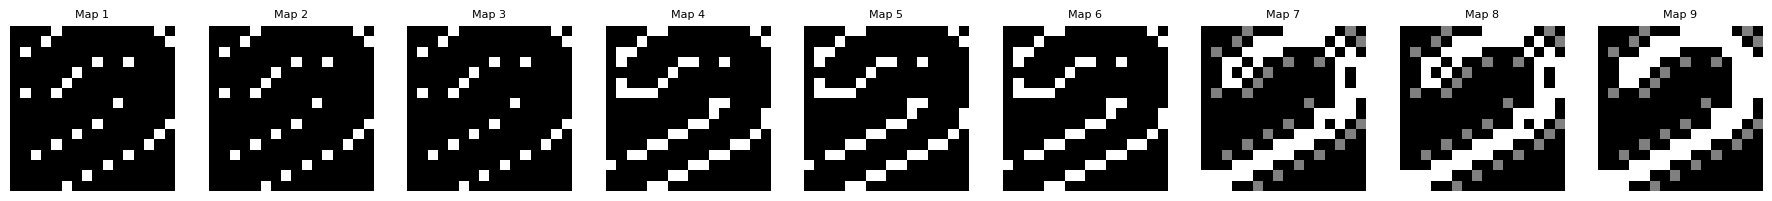

In [ ]:
def visualize_feature_maps(model, input_image, layer_name):
    """
    Visualize feature maps from a specific layer.

    :param model: Trained Keras model.
    :param input_image: Input image as a numpy array of shape (1, height, width, channels).
    :param layer_name: Name of the layer to visualize.
    """
    print(f"Initializing model for visualization from layer: {layer_name}")

    # Check if the layer exists
    try:
        layer_output = model.get_layer(layer_name).output
    except ValueError:
        available_layers = [layer.name for layer in model.layers]
        raise ValueError(
            f"Layer '{layer_name}' not found in the model. "
            f"Available layers: {available_layers}"
        )

    # Create a submodel that outputs the desired layer's activations
    submodel = tf.keras.Model(inputs=model.input, outputs=layer_output)

    # Get feature maps
    feature_maps = submodel.predict(input_image)

    # Plot feature maps
    num_maps = feature_maps.shape[-1]
    maps_per_row = 10
    num_rows = (num_maps + maps_per_row - 1) // maps_per_row  # Calculate total rows needed

    plt.figure(figsize=(maps_per_row * 2, num_rows * 2))
    for i in range(num_maps):
        plt.subplot(num_rows, maps_per_row, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap="gray")
        plt.axis("off")
        plt.title(f"Map {i + 1}", fontsize=8)
    plt.tight_layout()
    plt.show()


# Create the model
model = create_lenet5_with_ca(input_shape=(32, 32, 1), num_classes=3)

# Load a sample MNIST image
x_data, y_data = load_and_preprocess_clef(zip_file_path)
test_image = x_data[51]  # Shape: (28, 28, 1)

# Add batch dimension, shape becomes (1, 28, 28, 1)
test_image = np.expand_dims(test_image, axis=0)

# Initialize the model by calling it
_ = model(test_image)  # Ensures graph initialization


# Visualize feature maps
layer_name = "ca_layer_2"  # Use the desired layer name
visualize_feature_maps(model, test_image, layer_name)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


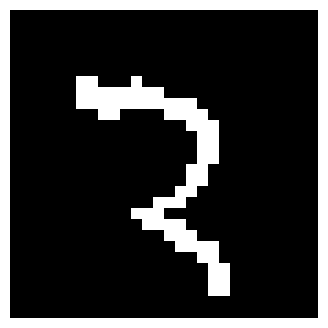

In [ ]:
x_data, y_data = load_and_preprocess_mnist()
test_image = x_data[500]  # Shape: (28, 28, 1)
plt.figure(figsize=(4, 4))
plt.imshow(test_image, cmap='gray', interpolation='nearest')
#plt.title("Original Image")
plt.axis('off')
plt.show()

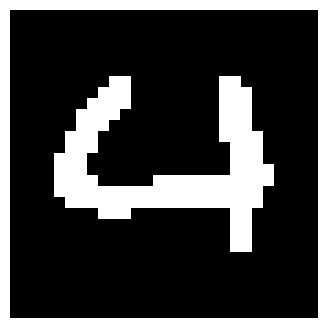

In [ ]:
x_data, y_data = load_and_preprocess_mnist()
test_image = x_data[60]  # Shape: (28, 28, 1)
plt.figure(figsize=(4, 4))
plt.imshow(test_image, cmap='gray', interpolation='nearest')
#plt.title("Original Image")
plt.axis('off')
plt.show()

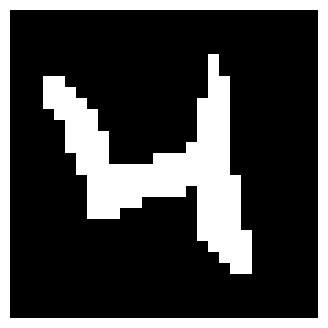

In [ ]:
x_data, y_data = load_and_preprocess_mnist()
test_image = x_data[20]  # Shape: (28, 28, 1)
plt.figure(figsize=(4, 4))
plt.imshow(test_image, cmap='gray', interpolation='nearest')
#plt.title("Original Image")
plt.axis('off')
plt.show()